### Adding scripts to the path of the notebook

In [1]:
import os, sys

current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

d:\KifiyaAIM-Course\Week - 5\EthioMart_E-Commerce_NER\notebooks


### Import Statements

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load the CoNLL dataset

In [3]:
from scripts.util import read_conll

In [4]:
PATH = "../data/conll.txt"

data = read_conll(PATH)
data.head()

,tokens,lables
0,"[ቴሌግራምtmemodernshoppingcenter, በአዲስ, ነገረ, ሁሌም,...","[O, O, O, O, O, O, O, O, O, B-Product, O, O, O..."
1,"[ቴሌግራምtmemodernshoppingcenter, በአዲስ, ነገረ, ሁሌም,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[ቴሌግራምtmemodernshoppingcenter, በአዲስ, ነገረ, ሁሌም,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[ቴሌግራምtmemodernshoppingcenter, በአዲስ, ነገረ, ሁሌም,...","[O, O, O, O, O, O, O, O, O, O, O, B-Product, O..."
4,"[ቴሌግራምtmemodernshoppingcenter, በአዲስ, ነገረ, ሁሌም,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


#### Prep the data

- Encode the NER labels

In [5]:
# define the unique labels
unique_labels = ['I-PRICE', 'B-PRICE', "B-LOCATION", "B-Product", "O"]

# now encode them to integers and create mappins between str and int and viceversa
enc_to_str = {i: value for i,value in enumerate(unique_labels)}
str_to_enc = {value: i for i,value in enumerate(unique_labels)}

In [6]:
data['lables'] = data['lables'].apply(lambda x: [str_to_enc[label] for label in x])

- Convert the data frame into a huggingface dataset

In [7]:
from datasets import Dataset, Features, Sequence, Value

d:\KifiyaAIM-Course\Week - 5\EthioMart_E-Commerce_NER\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# define the features/internal structure of the dataset 
feats = Features({
    'tokens': Sequence(Value('string')),
    'lables': Sequence(Value('int32'))
})

# now convert the dataframe into a huggingface dataset  
dataset = Dataset.from_pandas(data[['tokens', 'lables']], features=feats)

- Tokenize and align the lables for each of the models

    The models are **mBert**, **bert-tiny-amharic**, **DistilBert**

In [9]:
from scripts.tokenizer import Tokenizer

- Load the tokenizers using custom class

In [10]:
bert_tiny_tokenizer = Tokenizer(model_name='rasyosef/bert-tiny-amharic')
bert_tiny_tokenizer.load_tokenizer()

In [11]:
mbert_tokenizer = Tokenizer(model_name='bert-base-multilingual-cased')
mbert_tokenizer.load_tokenizer()

d:\KifiyaAIM-Course\Week - 5\EthioMart_E-Commerce_NER\venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
distil_bert_tokenizer = Tokenizer(model_name='distilbert-base-multilingual-cased')
distil_bert_tokenizer.load_tokenizer()

- Tokenize the dataset

In [13]:
tokenized_bert_tiny = dataset.map(bert_tiny_tokenizer.tokenize_and_align, batched=True)
tokenized_mbert = dataset.map(mbert_tokenizer.tokenize_and_align, batched=True)
tokenized_distil_bert = dataset.map(distil_bert_tokenizer.tokenize_and_align, batched=True)

Map: 100%|██████████| 2161/2161 [00:00<00:00, 2682.43 examples/s]


- Split the datasets into training and testing sets

In [14]:
train_test_bert_tiny = tokenized_bert_tiny.train_test_split(test_size=0.1)
train_test_mbert = tokenized_mbert.train_test_split(test_size=0.1)
train_test_distill_bert = tokenized_distil_bert.train_test_split(test_size=0.1)

#### Start Training

In [15]:
from transformers import TrainingArguments

- Set training arguments

In [16]:
training_args = TrainingArguments(
    output_dir='./training_result',
    eval_strategy="epoch",     # Evaluates at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=3,
    weight_decay=0.01,               # Strength of weight decay
    max_grad_norm=1.0,  # Gradient clipping
    logging_dir='./logs',            # Directory for storing logs
    logging_strategy="steps",        # Log at regular intervals
    logging_steps=50,                # Log every 50 steps
    save_strategy="epoch",           # Save model at the end of each epoch
    report_to="none",                # Only show logs in the output (no TensorBoard)
    use_cpu=True,  # Force training to happen on CPU,
    load_best_model_at_end=True,     # Load the best model (based on metric) at the end
    metric_for_best_model="eval_loss",# Metric used to determine the best model
    save_total_limit=1,              # Only keep the best model, delete the others  
)

- Load and finetune the models

In [17]:
from transformers import AutoModelForTokenClassification

In [18]:
bert_tiny_model = AutoModelForTokenClassification.from_pretrained("rasyosef/bert-tiny-amharic", num_labels=len(unique_labels))
mbert_model = AutoModelForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(unique_labels))
distil_bert_model = AutoModelForTokenClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=len(unique_labels))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at rasyosef/bert-tiny-amharic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Define an evaluation function

In [19]:
from scripts.util import compute_metrics

- Define trainers for models

In [20]:
# rename columns
train_test_bert_tiny = train_test_bert_tiny.rename_columns({"lables" : "labels"})

In [21]:
train_test_distill_bert = train_test_distill_bert.rename_columns({"lables" : "labels"})
train_test_mbert = train_test_mbert.rename_columns({"lables" : "labels"})

In [22]:
from transformers import Trainer

bert_tiny_trainer = Trainer(
    model=bert_tiny_model,
    args=training_args,
    train_dataset=train_test_bert_tiny['train'],
    eval_dataset=train_test_bert_tiny['test'],
    compute_metrics=compute_metrics
)

mbert_model_trainer = Trainer(
    model=mbert_model,
    args=training_args,
    train_dataset=train_test_bert_tiny['train'],
    eval_dataset=train_test_bert_tiny['test'],
    compute_metrics=compute_metrics
)

distil_bert_trainer = Trainer(
    model=distil_bert_model,
    args=training_args,
    train_dataset=train_test_bert_tiny['train'],
    eval_dataset=train_test_bert_tiny['test'],
    compute_metrics=compute_metrics
)

- Train and evaluate the models

In [23]:
print("########## Started training for bert_tiny_amharic ##########")
bert_tiny_trainer.train()

print("########## Started training for distill_bert ##########")
distil_bert_trainer.train()

########## Started training for bert_tiny_amharic ##########


 14%|█▍        | 51/366 [00:08<00:57,  5.52it/s]

{'loss': 1.4672, 'grad_norm': 6.471359729766846, 'learning_rate': 1.726775956284153e-05, 'epoch': 0.41}


 28%|██▊       | 101/366 [00:17<00:46,  5.71it/s]

{'loss': 0.9748, 'grad_norm': 5.204914569854736, 'learning_rate': 1.4535519125683062e-05, 'epoch': 0.82}


                                                 
 33%|███▎      | 122/366 [00:21<00:39,  6.16it/s]

{'eval_loss': 0.618209958076477, 'eval_precision': 0.9554659605332032, 'eval_recall': 0.9532835321663508, 'eval_f1': 0.9304839545661624, 'eval_runtime': 0.5965, 'eval_samples_per_second': 363.792, 'eval_steps_per_second': 23.47, 'epoch': 1.0}


 41%|████▏     | 151/366 [00:26<00:35,  5.99it/s]

{'loss': 0.6546, 'grad_norm': 3.9650707244873047, 'learning_rate': 1.1803278688524591e-05, 'epoch': 1.23}


 55%|█████▍    | 201/366 [00:43<00:29,  5.64it/s]

{'loss': 0.4911, 'grad_norm': 2.92952823638916, 'learning_rate': 9.071038251366122e-06, 'epoch': 1.64}


                                                 
 67%|██████▋   | 244/366 [00:51<00:17,  6.97it/s]

{'eval_loss': 0.3570058345794678, 'eval_precision': 0.9554659605332032, 'eval_recall': 0.9532835321663508, 'eval_f1': 0.9304839545661624, 'eval_runtime': 0.6394, 'eval_samples_per_second': 339.391, 'eval_steps_per_second': 21.896, 'epoch': 2.0}


 69%|██████▊   | 251/366 [00:52<00:21,  5.44it/s]

{'loss': 0.405, 'grad_norm': 2.3166849613189697, 'learning_rate': 6.338797814207651e-06, 'epoch': 2.05}


 82%|████████▏ | 300/366 [01:03<00:37,  1.78it/s]

{'loss': 0.3678, 'grad_norm': 2.1093909740448, 'learning_rate': 3.6065573770491806e-06, 'epoch': 2.46}


 96%|█████████▌| 350/366 [01:41<00:11,  1.42it/s]

{'loss': 0.3548, 'grad_norm': 1.7539185285568237, 'learning_rate': 8.743169398907105e-07, 'epoch': 2.87}


                                                 
100%|██████████| 366/366 [01:57<00:00,  1.20it/s]

{'eval_loss': 0.3222096562385559, 'eval_precision': 0.9554659605332032, 'eval_recall': 0.9532835321663508, 'eval_f1': 0.9304839545661624, 'eval_runtime': 2.7826, 'eval_samples_per_second': 77.985, 'eval_steps_per_second': 5.031, 'epoch': 3.0}


100%|██████████| 366/366 [01:57<00:00,  3.10it/s]


{'train_runtime': 117.8492, 'train_samples_per_second': 49.487, 'train_steps_per_second': 3.106, 'train_loss': 0.6599542325963088, 'epoch': 3.0}
########## Started training for distill_bert ##########


 14%|█▎        | 50/366 [03:04<14:29,  2.75s/it] 

{'loss': 0.2844, 'grad_norm': 0.5384348630905151, 'learning_rate': 1.726775956284153e-05, 'epoch': 0.41}


 27%|██▋       | 100/366 [04:55<09:45,  2.20s/it]

{'loss': 0.0371, 'grad_norm': 0.4415183663368225, 'learning_rate': 1.4535519125683062e-05, 'epoch': 0.82}


 33%|███▎      | 122/366 [05:50<07:58,  1.96s/it]

{'eval_loss': 0.02155637927353382, 'eval_precision': 0.9954033192472381, 'eval_recall': 0.9948712231017951, 'eval_f1': 0.9948474134503972, 'eval_runtime': 7.0691, 'eval_samples_per_second': 30.697, 'eval_steps_per_second': 1.98, 'epoch': 1.0}


 41%|████      | 150/366 [06:54<08:02,  2.23s/it]

{'loss': 0.0169, 'grad_norm': 0.06557698547840118, 'learning_rate': 1.1803278688524591e-05, 'epoch': 1.23}


 55%|█████▍    | 200/366 [08:47<06:13,  2.25s/it]

{'loss': 0.0096, 'grad_norm': 0.2595888376235962, 'learning_rate': 9.071038251366122e-06, 'epoch': 1.64}


 67%|██████▋   | 244/366 [10:32<04:03,  1.99s/it]

{'eval_loss': 0.011272909119725227, 'eval_precision': 0.9981047812914798, 'eval_recall': 0.9981045824506634, 'eval_f1': 0.998043679355232, 'eval_runtime': 7.218, 'eval_samples_per_second': 30.064, 'eval_steps_per_second': 1.94, 'epoch': 2.0}


 68%|██████▊   | 250/366 [10:47<05:08,  2.66s/it]

{'loss': 0.0094, 'grad_norm': 0.059526823461055756, 'learning_rate': 6.338797814207651e-06, 'epoch': 2.05}


 82%|████████▏ | 300/366 [12:39<02:28,  2.25s/it]

{'loss': 0.0064, 'grad_norm': 0.2163209170103073, 'learning_rate': 3.6065573770491806e-06, 'epoch': 2.46}


 96%|█████████▌| 350/366 [14:35<00:38,  2.39s/it]

{'loss': 0.0068, 'grad_norm': 0.035499781370162964, 'learning_rate': 8.743169398907105e-07, 'epoch': 2.87}


                                                 
100%|██████████| 366/366 [15:20<00:00,  2.01s/it]

{'eval_loss': 0.009706705808639526, 'eval_precision': 0.9982080819808229, 'eval_recall': 0.9982160776006244, 'eval_f1': 0.9981530749701848, 'eval_runtime': 7.0947, 'eval_samples_per_second': 30.586, 'eval_steps_per_second': 1.973, 'epoch': 3.0}


100%|██████████| 366/366 [15:22<00:00,  2.52s/it]

{'train_runtime': 922.2896, 'train_samples_per_second': 6.323, 'train_steps_per_second': 0.397, 'train_loss': 0.050938927858579355, 'epoch': 3.0}


TrainOutput(global_step=366, training_loss=0.050938927858579355, metrics={'train_runtime': 922.2896, 'train_samples_per_second': 6.323, 'train_steps_per_second': 0.397, 'total_flos': 190502552844288.0, 'train_loss': 0.050938927858579355, 'epoch': 3.0})

- Now evaluate the trained models

In [24]:
evaluation = {}

evaluation['bert_tiny'] = bert_tiny_trainer.evaluate()
evaluation['distil_bert'] = distil_bert_trainer.evaluate()

100%|██████████| 14/14 [00:06<00:00,  2.09it/s]


- Create plots from the evaluation

In [25]:
time_eval = [evaluation[model]['eval_loss'] for model in evaluation]
lost_eval = [evaluation[model]['eval_runtime'] for model in evaluation]

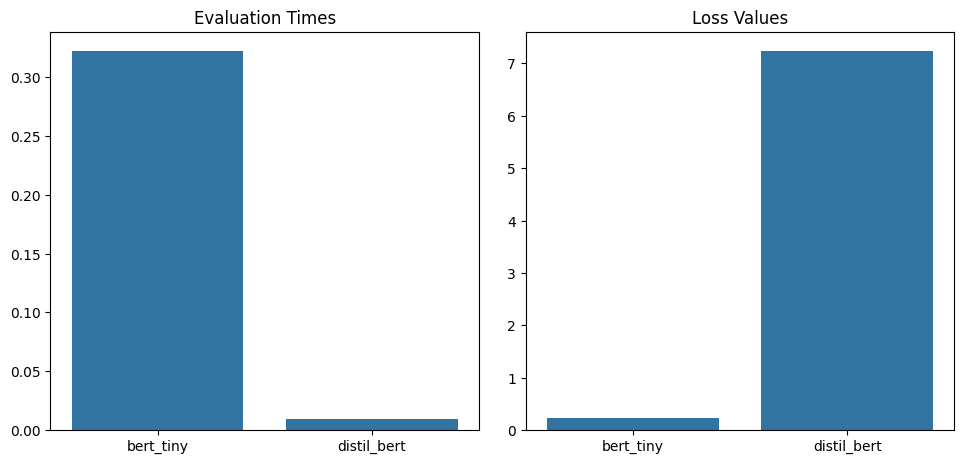

In [46]:
fig, ax = plt.subplots(nrows=1 , ncols=2, figsize=(10,5))

# plot the time eval
sns.barplot(ax=ax[0], x=evaluation.keys(), y=time_eval)
ax[0].set_title('Evaluation Times')

# plot the loss eval
sns.barplot(ax=ax[1], x=evaluation.keys(), y=lost_eval)
ax[1].set_title('Loss Values')

plt.tight_layout(pad=2)
plt.show()

- Model Perfomance

In [31]:
precision_scores = [evaluation[model]['eval_precision'] for model in evaluation]
recall_scores = [evaluation[model]['eval_recall'] for model in evaluation]
f1_scores = [evaluation[model]['eval_f1'] for model in evaluation]

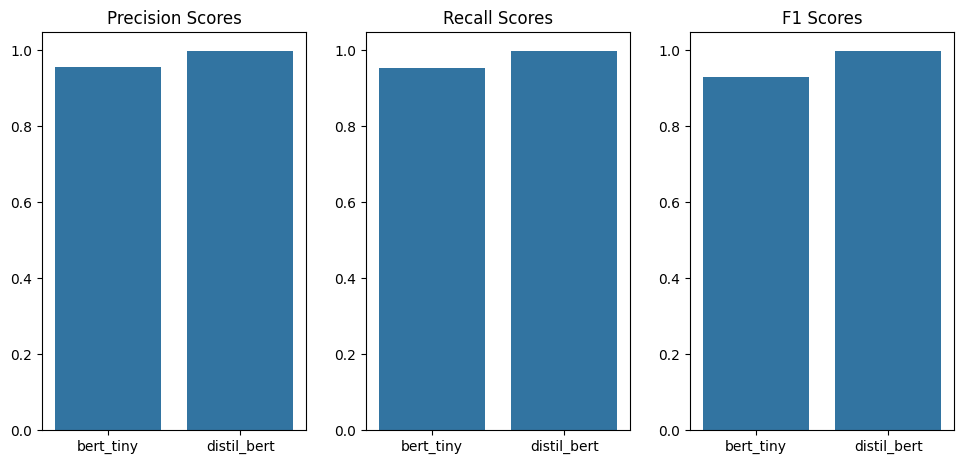

In [45]:
fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(10,5))

# plot the precision
sns.barplot(ax=ax[0], x=evaluation.keys(), y=precision_scores)
ax[0].set_title('Precision Scores')

# plot the recall
sns.barplot(ax=ax[1], x=evaluation.keys(), y=recall_scores)
ax[1].set_title('Recall Scores')

# plot the f1 score
sns.barplot(ax=ax[2], x=evaluation.keys(), y=f1_scores)
ax[2].set_title('F1 Scores')

plt.tight_layout(pad=2)
plt.show()